## Overfitting and Underfitting

1. overfitting
-> 학습오차는 low, 테스트오차는 high. bias는 low, variance는 high.

2. underfitting
-> 학습오차는 high, 테스트오차는 low. bias는 high, variance는 low.

* Kinds of Data
1. learning data
-> 모델 학습을 위한 데이터

2. validation data
-> 모델 검증, 즉 하이퍼 파라미터 튜닝을 위해 사용하는 데이터

3. test data
-> 모델의 최종적인 성능을 측정하기 위한 데이터



* Solution preventing overfitting

-> Regularization, Dropout, improving data, weight initialization....etc




## Regularization
 
 1. L1
 -> 가중치의 절댓값을 최소화하는 것이기 때문에 가중치가 정확하게 0이 될 수 있음.(weight가 sparse함)
    위와 같은 특성덕에, feature selection이 가능함.
    
 2. L2 
 -> L1에 비해, 계산 용이, 가중치의 제곱을 최소화하는 것이기 때문에 정확히 0이 되는 가중치는 거의 없음.
 
 3. elastic regularization
 -> L1과 L2를 동시에 사용함.

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [5]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

In [6]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

c:\users\user\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
mnist_test.__getitem__(0)[0].size(), mnist_test.__len__()

torch.Size([1, 28, 28]) 60000


(torch.Size([1, 28, 28]), 10000)

In [8]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),  # 28 x 28
            nn.ReLU(),
            nn.Conv2d(16,32,3,padding=1), # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2,2),            # 14 x 14
            nn.Conv2d(32,64,3,padding=1), # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2,2)             #  7 x 7
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )       
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()

# 정형화는 weight_decay로 줄 수 있음.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.1)

cuda:0


In [14]:
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
    if i % 10 == 0:
        print(loss)          

tensor(2.3054, device='cuda:0', grad_fn=<NllLossBackward>)


In [15]:
correct = 0
total = 0

with torch.no_grad():
    for image,label in test_loader:
        x = image.to(device)
        y_= label.to(device)

        output = model.forward(x)
        _,output_index = torch.max(output,1)

        total += label.size(0)
        correct += (output_index == y_).sum().float()

    print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 10.09615421295166


## Dropout

-> 특정 뉴런을 0으로 만들어주는 것. 수용력이 낮은 모델들의 앙상블 개념으로도 볼 수 있음. 테스트할때는 모든 뉴런의 값을 먼저 계산하고 이에 (1-p)를 곱해주고 전달함.(여기서 p는 하나의 뉴런이 0이 될 확률을 말한다)

   

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),  # 28 x 28
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(16,32,3,padding=1), # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2,2), 
            nn.Dropout2d(0.2),          # 14 x 14
            nn.Conv2d(32,64,3,padding=1), # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2,2)             #  7 x 7
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )       
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

In [18]:
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.1)

In [20]:
model.train()
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
    if i % 10 == 0:
        print(loss)     

tensor(2.3034, device='cuda:0', grad_fn=<NllLossBackward>)


In [21]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for image,label in test_loader:
        x = image.to(device)
        y_= label.to(device)

        output = model.forward(x)
        _,output_index = torch.max(output,1)

        total += label.size(0)
        correct += (output_index == y_).sum().float()

    print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 15.95552921295166


## Data Augumentation


-> 데이터 증강은 말그대로, 데이터를 늘리는 방법이다. 주어진 그림을 좌우, 상하 반전하는 방법이나, 임의의 크기로 잘라낸 다음(crop) 사이즈를 키워 맞추기도 함.


In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
import random
from scipy import ndimage


def random_rotate2d(img):
    rand = random.randrange(0,360,90)
    img = ndimage.interpolation.rotate(img, rand, reshape=False, order=0, mode='reflect')
    return img

In [56]:
mnist_train = dset.MNIST("./", train=True, 
                         transform = transforms.Compose([
                             transforms.Resize(34),                             # 원래 28x28인 이미지를 34x34로 늘립니다.
                             transforms.CenterCrop(28),                         # 중앙 28x28를 뽑아냅니다.
                             transforms.RandomHorizontalFlip(),                 # 랜덤하게 좌우반전 합니다.
                             transforms.Lambda(random_rotate2d),
                             transforms.ToTensor(),                             # 이미지를 텐서로 변형합니다.
                         ]),
                         target_transform=None,
                         download=True)


mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [57]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=0,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=0,drop_last=True)

0


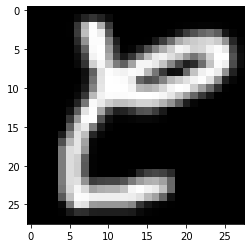

1


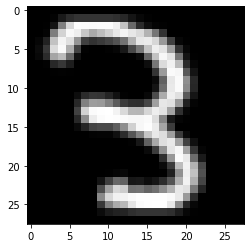

2


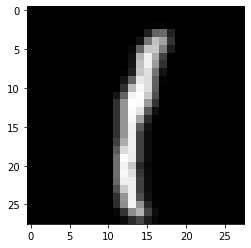

3


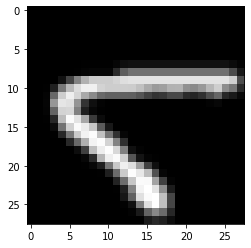

4


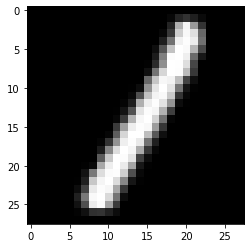

5


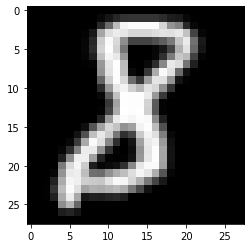

6


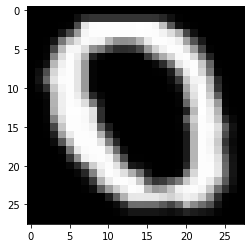

In [58]:
# 이미지를 보면 알수 있듯이 augmentation을 데이터에 맞게 하지 않으면 말도 안되는걸 학습하게 됩니다.
# 90도 돌리거나 좌우반전을 함으로써 의미를 잃어버리는 경우도 있기 때문에 데이터에 맞는 augmentation을 해야합니다.

for idx,(img,label) in enumerate(train_loader):
    print(idx)
    plt.imshow(img[0,0,...],cmap="gray")
    plt.show()
    if idx > 5:
        break

## Initialization
-> 모델이 학습되는 도중에 gradient vanishing, exploding 을 겪지 않도록 하거나, 손실함수의 공간을 최적화가 쉬운 형태로 바꾸는 가중치의 초기상태를 결정하는 방법.
대표적인 방법으로, Xavier초기화와 He초기화가 있다. Xavier 초기화는 sigmoid나 tanh를 활성화함수로 사용할 때, 쓰면 유리하고, ReLU를 사용할 경우, He 초기화를 활용하는 것이 보다 유리하다.

In [74]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),  # 28 x 28
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(16,32,3,padding=1), # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2,2), 
            nn.Dropout2d(0.2),          # 14 x 14
            nn.Conv2d(32,64,3,padding=1), # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2,2)             #  7 x 7
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )       
        
        #initialization, 모델의 module들을 차례로 돌면서, 가중치를 초기화한다.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                '''# Init with small numbers
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.fill_(0)
            
                # Xaivier Initialization
                init.xavier_normal(m.weight.data)
                m.bias.data.fill_(0)'''
            
                # Kaming Initialization
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill(0)
            
            elif isinstance(m, nn.Linear):
                '''# Init with small numbers
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.fill_(0)
            
                # Xaivier Initialization
                init.xavier_normal(m.weight.data)
                m.bias.data.fill_(0)'''
                # Kaming Initialization
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill(0)
    